# Обработка входных данных

In [1]:
import os
import zipfile
from pathlib import Path
from random import shuffle
from PIL import Image
import shutil
import torch

# Configurations
IMAGENET_ARCHIVE = "archive.zip"  # Name of Tiny ImageNet ZIP file
DOGS_VS_CATS_ARCHIVE = "dogs-vs-cats.zip"  # Name of Dogs-vs-Cats ZIP file
EXTRACT_DIR = "extracted_data"  # Directory for extracted datasets
OUTPUT_DIR = "processed_data"  # Directory for the prepared dataset
CLASS_NAMES = ["cats", "dogs", "other"]  # Target classes
BALANCED_SIZE = 12500  # Number of images per class
IMG_HEIGHT = 64
IMG_WIDTH = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
def extract_zip(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zf:
        zf.extractall(extract_to)
    print(f"Extracted {zip_path} to {extract_to}")

# Resize and save image
import torchvision.transforms as transforms
import random

def resize_and_save(image_path, output_path, size=(64, 64)):
    try:
        with Image.open(image_path) as img:
            img = img.convert("RGB")  # Ensure 3 channels
            img = img.resize(size, Image.Resampling.LANCZOS)  # Updated from ANTIALIAS
            img.save(output_path)
    except Exception as e:
        print(f"Error processing {image_path}: {e}")

def prepare_class(source_paths, output_class_dir, limit, label_filter=None, exclude_labels=None):
    """
    Prepares data for a specific class by resizing and saving images.
    """
    all_images = []

    for path in source_paths:
        if "dogs-vs-cats" in path:  # Handle Dogs-vs-Cats dataset
            for file in Path(path).rglob("*.jpg"):
                if label_filter:
                    # Include only files with the specified label in the name
                    if file.name.startswith(label_filter):
                        all_images.append(file)
                else:
                    all_images.append(file)

        elif "tiny-imagenet-200" in path:  # Handle Tiny ImageNet dataset
            if "train" in path:
                for subfolder in Path(path).iterdir():
                    if exclude_labels and subfolder.name in exclude_labels:
                        continue  # Skip subfolders corresponding to excluded labels
                    images_folder = subfolder / "images"
                    if images_folder.exists():
                        all_images.extend(images_folder.rglob("*.jpeg"))
            elif "test" in path:
                all_images.extend(Path(path).rglob("*.jpeg"))

    # Shuffle and limit the dataset size
    shuffle(all_images)
    all_images = all_images[:limit]

    # Ensure output directory exists
    os.makedirs(output_class_dir, exist_ok=True)

    # Resize and save images
    for idx, img_path in enumerate(all_images):
        output_path = os.path.join(output_class_dir, f"{idx}.jpg")
        resize_and_save(img_path, output_path, size=(IMG_WIDTH, IMG_HEIGHT))


if not os.path.exists(EXTRACT_DIR):
    os.makedirs(EXTRACT_DIR, exist_ok=True)
    print("Extracting datasets...")
    extract_zip(IMAGENET_ARCHIVE, EXTRACT_DIR)
    extract_zip(DOGS_VS_CATS_ARCHIVE, EXTRACT_DIR)
else:
    print("Datasets already extracted.")


#### Пометим из Tiny-ImageNet классы, отвечающие за кошек и собак

Datasets already extracted.


In [3]:
cat_dog_class_ids = {
    "n02085620",
    "n02094433",
    "n02099601",
    "n02099712", 
    "n02106662",
    "n02113799",
    "n02123045", 
    "n02123394",
    "n02124075",
}

#### Соберём сам датасет в df и рассплитим его на тренировочный и тестовый

In [4]:
dogs_vs_cats_train = os.path.join(EXTRACT_DIR, "dogs-vs-cats", "train")
tiny_imagenet_train = os.path.join(EXTRACT_DIR, "tiny-imagenet-200", "train")

# Prepare "cats" class
if not os.path.exists(os.path.join(OUTPUT_DIR, "cats")):
    prepare_class(
        source_paths=[dogs_vs_cats_train],
        output_class_dir=os.path.join(OUTPUT_DIR, "cats"),
        limit=BALANCED_SIZE,
        label_filter="cat"
    )

# Prepare "dogs" class
if not os.path.exists(os.path.join(OUTPUT_DIR, "dogs")):
    prepare_class(
        source_paths=[dogs_vs_cats_train],
        output_class_dir=os.path.join(OUTPUT_DIR, "dogs"),
        limit=BALANCED_SIZE,
        label_filter="dog"
    )

# Prepare "other" class
if not os.path.exists(os.path.join(OUTPUT_DIR, "other")):
    prepare_class(
        source_paths=[tiny_imagenet_train],
        output_class_dir=os.path.join(OUTPUT_DIR, "other"),
        limit=2*BALANCED_SIZE,
        exclude_labels=cat_dog_class_ids
    )

# Обучаем сетки

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from IPython.display import clear_output
from torch.utils.data import DataLoader, Dataset

#### Самописный датасет для DataLoader

In [6]:
def make_loader(df, batch_size=32, shuffle=True):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    class InlineDataset(Dataset):
        def __init__(self, dataframe):
            self.dataframe = dataframe

        def __len__(self):
            return len(self.dataframe)

        def __getitem__(self, idx):
            # Get the row from the DataFrame
            row = self.dataframe.iloc[idx]
            img_path = row["file_path"]
            label = row["binary_label"]

            # Load and transform the image
            image = Image.open(img_path)
            image = transform(image)

            return image.to(device), torch.tensor(label).to(device)

    dataset = InlineDataset(df)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

    return dataloader

In [7]:
def make_loader(df, batch_size=32, shuffle=True):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    class InlineDataset(Dataset):
        def __init__(self, dataframe):
            self.dataframe = dataframe

        def __len__(self):
            return len(self.dataframe)

        def __getitem__(self, idx):
            # Get the row from the DataFrame
            row = self.dataframe.iloc[idx]
            img_path = row["file_path"]
            label = row["label"]

            # Load and transform the image
            image = Image.open(img_path)
            image = transform(image)

            return image.to(device), torch.tensor(label).to(device)

    dataset = InlineDataset(df)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

    return dataloader

In [8]:
BATCH_SIZE = 32
NUM_CLASSES = 3
EPOCHS = 10

#### Поделим данные и переведём в тензоры

In [9]:
data = []
for label, class_name in enumerate(CLASS_NAMES):
    class_path = os.path.join(OUTPUT_DIR, class_name)
    for file_name in os.listdir(class_path):
        if file_name.endswith(('jpg', 'jpeg', 'png')):  # Adjust extensions as needed
            file_path = os.path.join(class_path, file_name)
            data.append((file_path, label))  # (file path, label)

# Convert to DataFrame
df = pd.DataFrame(data, columns=["file_path", "label"])

# Split data into train and test sets
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)
print(len(train_data))
print(len(test_data))

40000
10000


#### Функции для обучения

In [10]:
import matplotlib.pyplot as plt
def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    
    points = np.array(val_history)
    
    plt.scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()

In [11]:
def train(model, opt, criterion, n_epochs, save_path, all_classes=True):
    train_log, train_acc_log = [], []
    val_log, val_acc_log = [], []
    best_val_loss = float('inf')
    for epoch in range(n_epochs):
        print(f"Epoch {epoch+1}/{n_epochs}")
        print("Training...")
        train_loss, train_acc = train_epoch(model, opt, criterion, batchsize=BATCH_SIZE)
        print("Done\nValidating...")
        val_loss, val_acc = test(model, criterion)
        print("Done")
        train_log.extend(train_loss)
        train_acc_log.extend(train_acc)
        x = 4 if all_classes else 2
        steps = (BALANCED_SIZE * x * 0.8) / BATCH_SIZE
        val_log.append((steps * (epoch + 1), np.mean(val_loss)))
        val_acc_log.append((steps * (epoch + 1), np.mean(val_acc)))

        clear_output()
        plot_history(train_log, val_log)    
        plot_history(train_acc_log, val_acc_log, title='accuracy')  

        if np.mean(val_loss) < best_val_loss:
            best_val_loss = np.mean(val_loss)
            torch.save(model.state_dict(), save_path)
            print(f"Best model saved with loss {best_val_loss}")

In [12]:
def test(model, criterion):
    loss_log, acc_log = [], []
    model.eval()
    for batch_num, (x_batch, y_batch) in enumerate(test_loader):   
        # print(f"Batch {batch_num}/{len(test_loader)}")
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        data = Variable(x_batch).to(device)
        target = Variable(y_batch)
        target = target.type(torch.LongTensor) 
        target = target.to(device)

        output = model(data).squeeze(1)
        loss = criterion(output, target.float()).cuda()

        sigmoid = nn.Sigmoid()
        pred = (sigmoid(output) > 0.5).type(torch.LongTensor).cuda()
        acc = np.mean((pred == y_batch).cpu().numpy())
        
        acc_log.append(acc)
        
        loss = loss.item()
        loss_log.append(loss)
    print(loss_log)
    return loss_log, acc_log

In [13]:
def train_epoch(model, optimizer, criterion, batchsize=32): 
    loss_log, acc_log = [], []
    model.train()
    for batch_num, (x_batch, y_batch) in enumerate(train_loader):
        print(f"Batch {batch_num+1}/{len(train_loader)}")
        x_batch = x_batch.to(device)
        # y_batch = torch.unsqueeze(y_batch, 1)
        y_batch = y_batch.to(device)
        # print(y_batch.shape)
        data = Variable(x_batch).to(device)
        target = Variable(y_batch)
        target = target.type(torch.LongTensor) 
        target = target.to(device)
        # print(y_batch.shape)
        # print(target.shape)

        output = model(data).squeeze(1)
        # print(output.shape)
        # pred = torch.argmax(output, dim=1, keepdim = True).reshape(data.shape[0]).data.numpy()
        # print(pred == y_batch)
        # print(output)
        sigmoid = nn.Sigmoid()
        # print(sigmoid(output))
        pred = (sigmoid(output) > 0.5).type(torch.LongTensor).cuda()
        acc = np.mean((pred == y_batch).cpu().numpy())
        acc_log.append(acc)
        
        loss = criterion(output, target.float()).cuda()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        optimizer.step()
        optimizer.zero_grad()
        loss = loss.item()
        loss_log.append(loss)
    return loss_log, acc_log   

#### Обучение ResNet сети

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision import transforms

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample  # Downsample for matching dimensions when needed

    def forward(self, x):
        identity = x
        if self.downsample:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        out += identity  # Add skip connection
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, num_classes=3):
        super(ResNet, self).__init__()
        self.in_channels = 64

        # Начальная часть ResNet-18
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Основные блоки ResNet-18
        self.layer1 = self._make_layer(64, 64, 2, stride=1)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.layer4 = self._make_layer(256, 512, 2, stride=2)

        # Классификатор
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, blocks, stride):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        layers = []
        layers.append(ResidualBlock(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x
        

In [15]:
def prepare_datasets_for_tasks(train_df, test_df):
    # "Cats & Dogs vs Others"
    train_catdog_others = train_df.copy()
    train_catdog_others["label"] = train_catdog_others["label"].apply(lambda x: 0 if x in [0, 1] else 1)

    test_catdog_others = test_df.copy()
    test_catdog_others["label"] = test_catdog_others["label"].apply(lambda x: 0 if x in [0, 1] else 1)

    # "Cats vs Dogs"
    train_cats_dogs = train_df[train_df["label"].isin([0, 1])].copy()
    train_cats_dogs["label"] = train_cats_dogs["label"].apply(lambda x: 0 if x == 0 else 1)

    test_cats_dogs = test_df[test_df["label"].isin([0, 1])].copy()
    test_cats_dogs["label"] = test_cats_dogs["label"].apply(lambda x: 0 if x == 0 else 1)

    return (train_catdog_others, test_catdog_others), (train_cats_dogs, test_cats_dogs)

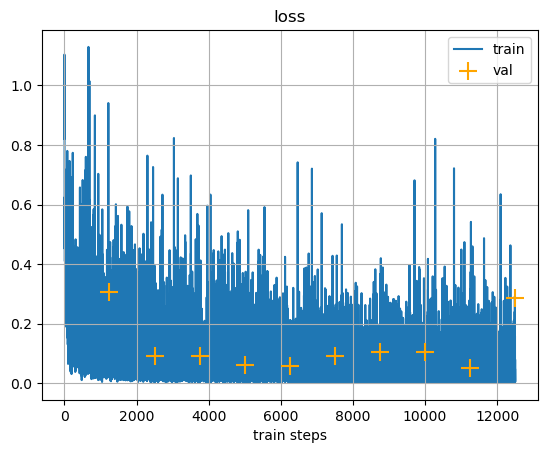

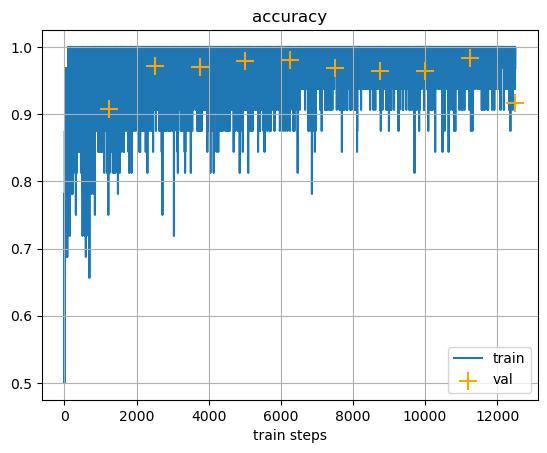

In [17]:
(train_catdog_others, test_catdog_others), (train_cats_dogs, test_cats_dogs) = prepare_datasets_for_tasks(train_data, test_data)

criterion = nn.BCEWithLogitsLoss()

print("Training Model 1: Cats & Dogs vs Others")
train_loader = make_loader(train_catdog_others, batch_size=BATCH_SIZE)
test_loader = make_loader(test_catdog_others, batch_size=BATCH_SIZE)

model1 = ResNet(num_classes=1).to(device)
optimizer1 = optim.Adam(model1.parameters(), lr=0.001, weight_decay=1e-4)
train(model1, optimizer1, criterion, EPOCHS, 'catsdogs_vs_others.pth')

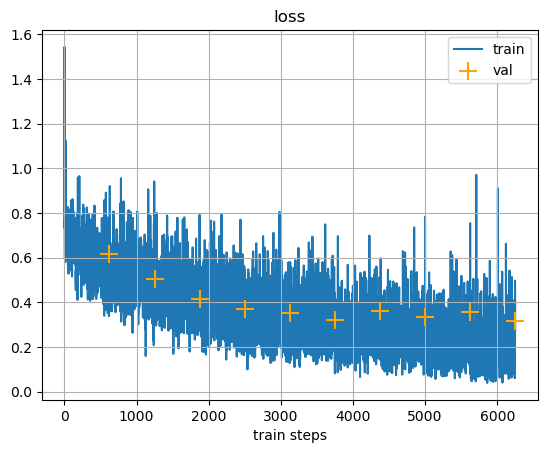

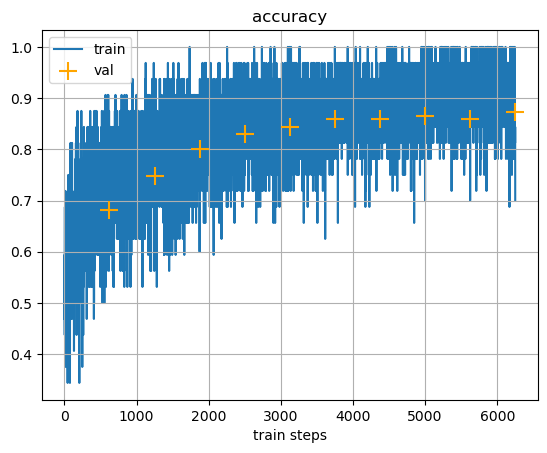

Best model saved with loss 0.3153453779163634


In [18]:
print("Training Model 2: Cats vs Dogs")
train_loader = make_loader(train_cats_dogs, batch_size=BATCH_SIZE)
test_loader = make_loader(test_cats_dogs, batch_size=BATCH_SIZE)

model2 = ResNet(num_classes=1).to(device)
optimizer2 = optim.Adam(model2.parameters(), lr=0.001, weight_decay=1e-4)
train(model2, optimizer2, criterion, EPOCHS, 'cats_vs_dogs.pth', all_classes=False)

In [25]:
class Ensemble:
    def __init__(self, model1, model2):
        """
        model1: "Cats & Dogs vs Others".
        model2: "Cats vs Dogs".
        """
        self.model1 = model1
        self.model2 = model2

    def eval(self, image, device='cuda'):
        self.model1.eval()
        self.model2.eval()

        with torch.no_grad():
            sigmoid = nn.Sigmoid()
            # Прогон через первую модель (Cats & Dogs vs Others)
            output1 = self.model1(image.to(device))
            prob1 = (sigmoid(output1) >= 0.5).int()
            if prob1[0] == 1:  # "Другое"
                return torch.tensor([2]).to(device)

            # Прогон через вторую модель (Cats vs Dogs)
            output2 = self.model2(image.to(device))
            prob2 = (sigmoid(output2) >= 0.5).int()

            return prob2[0]  # 0 - Кошка, 1 - Собака

In [26]:
def denormalize_image(tensor, mean, std):
    """
    tensor: Тензор изображения [C, H, W]
    mean: Список средних значений нормализации
    std: Список стандартных отклонений нормализации
    """
    mean = np.array(mean).reshape(3, 1, 1)
    std = np.array(std).reshape(3, 1, 1)
    image = tensor.cpu().numpy()  # Перевод в numpy
    image = (image * std) + mean  # Отмена нормализации
    image = np.clip(image, 0, 1)  # Обрезаем значения в диапазоне [0, 1]
    return image

In [27]:
import time
model1.load_state_dict(torch.load('catsdogs_vs_others.pth', weights_only=True))
model2.load_state_dict(torch.load('cats_vs_dogs.pth', weights_only=True))


mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

ensemble = Ensemble(model1, model2)
test_loader = make_loader(test_data, batch_size=1)
res = []
print(len(test_loader))
not_guessed = []
for batch_num, (x_batch, y_batch) in enumerate(test_loader):
    print(f"Batch {batch_num+1}/{len(test_loader)}")
    # image = x_batch[0]
    # image_denorm = denormalize_image(image, mean, std)
    # plt.imshow(np.transpose(image_denorm, (1, 2, 0)))  # Переводим [C, H, W] -> [H, W, C]
    # plt.show()
    pred = ensemble.eval(x_batch)
    # print(pred, y_batch)
    # print(pred, y_batch, pred == y_batch)
    res.append((pred == y_batch).int().cpu().numpy())
    if not pred == y_batch:
        not_guessed.append((x_batch, pred, y_batch))

10000
Batch 1/10000
Batch 2/10000
Batch 3/10000
Batch 4/10000
Batch 5/10000
Batch 6/10000
Batch 7/10000
Batch 8/10000
Batch 9/10000
Batch 10/10000
Batch 11/10000
Batch 12/10000
Batch 13/10000
Batch 14/10000
Batch 15/10000
Batch 16/10000
Batch 17/10000
Batch 18/10000
Batch 19/10000
Batch 20/10000
Batch 21/10000
Batch 22/10000
Batch 23/10000
Batch 24/10000
Batch 25/10000
Batch 26/10000
Batch 27/10000
Batch 28/10000
Batch 29/10000
Batch 30/10000
Batch 31/10000
Batch 32/10000
Batch 33/10000
Batch 34/10000
Batch 35/10000
Batch 36/10000
Batch 37/10000
Batch 38/10000
Batch 39/10000
Batch 40/10000
Batch 41/10000
Batch 42/10000
Batch 43/10000
Batch 44/10000
Batch 45/10000
Batch 46/10000
Batch 47/10000
Batch 48/10000
Batch 49/10000
Batch 50/10000
Batch 51/10000
Batch 52/10000
Batch 53/10000
Batch 54/10000
Batch 55/10000
Batch 56/10000
Batch 57/10000
Batch 58/10000
Batch 59/10000
Batch 60/10000
Batch 61/10000
Batch 62/10000
Batch 63/10000
Batch 64/10000
Batch 65/10000
Batch 66/10000
Batch 67/1000

In [28]:
print(f"Accuracy on test data: {100*np.mean(res):.2f}%")

Accuracy on test data: 92.17%


In [29]:
not_guessed = [(tensor[0], pred, truth) for (tensor, pred, truth) in not_guessed] 

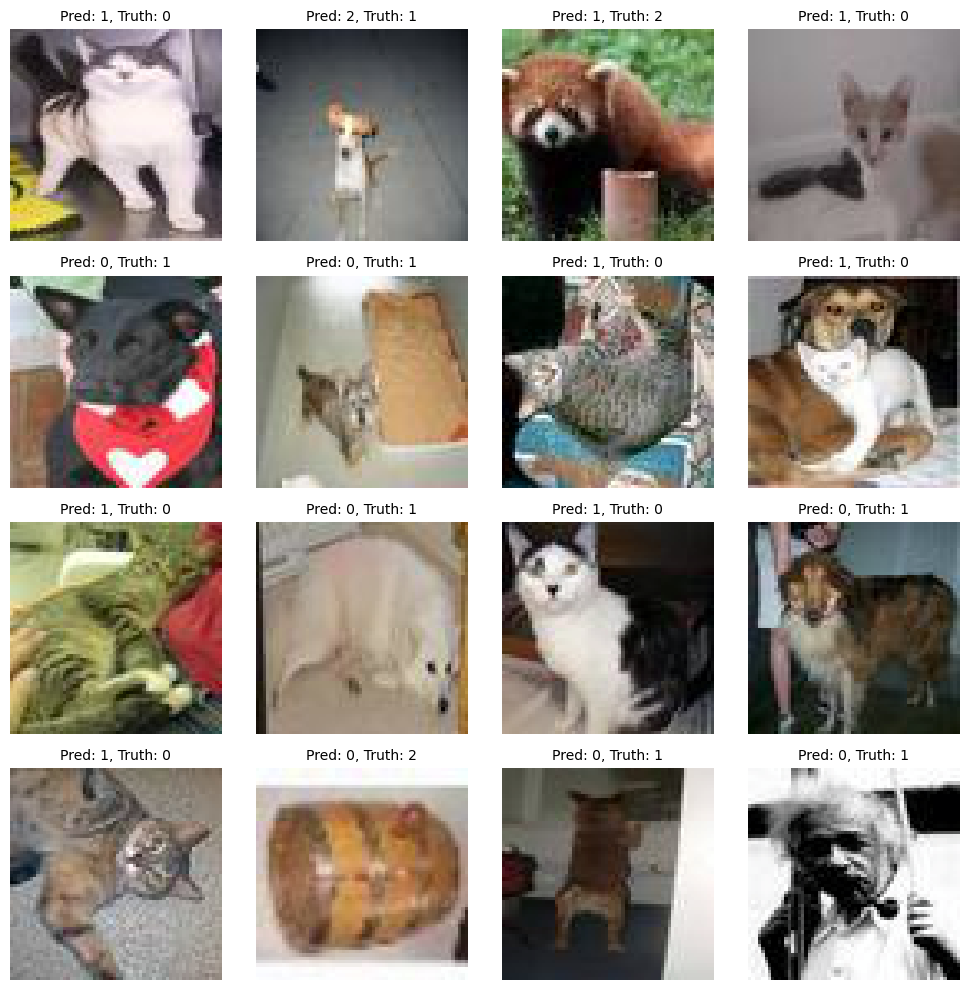

In [31]:
from random import shuffle

shuffle(not_guessed)
rows, cols = 4, 4  # Сетка 4x4

# Создание сетки изображений
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
axes = axes.flatten()

for idx, ((image, pred, truth), ax) in enumerate(zip(not_guessed, axes)):
    image_denorm = denormalize_image(image, mean, std)
    ax.imshow(np.transpose(image_denorm, (1, 2, 0)))  # Переводим [C, H, W] -> [H, W, C]
    ax.axis('off')  # Убираем оси
    ax.set_title(f"Pred: {pred[0]}, Truth: {truth[0]}", fontsize=10)

plt.tight_layout()
plt.show()